In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

<font size=6>**Introduction to Bayesian Statistics**</font>


# 1. The problem: Counting photons...

Typically, an X-ray imaging observation gives a collection of **events**: coordinates and energies of **individual photons** detected by the telescope. Essentially, we count photons, and this is why we usually refer to the photons as **counts**, while the **count rate** informs us about the number of photons per second. In general, the count rate scales with the flux of the field (or source) in the energy band of the telescope during the observation.

<table><tr>
<td> <img src="images/NGC1482_opt.jpg" alt="Drawing" style="height:400px;"/> </td>
<td> <img src="images/NGC1482.png" alt="Drawing" style="height: 400px;"/> </td>
</tr></table>

Using **source detection algorithms** we group photons together and generate a list of sources and the photons we got from each - namely, the *source region*. For a given source, the integrated energy of the photons from its source region gives us an estimate on the energy collected from the telescope. Of course, the response of the detector and absorption effects should be accounted for. Having many counts allows us to fit for the spectrum of the source. Modeling the detector properties, the intergalactic absorption and the spectra allows us to measure the *bolometric* flux of the source - the flux as if we could observe the source with a perfect detector. Provided we know the distance of the source we can convert from flux to luminosity... an intrinsic property of the source (which is what we usually care for)!

## 1.1. How many counts are we going to get?

<font size=3><u>**In-class discussion: If each photon count during the exposure (e.g., 50 ks) corresponds to luminosity $10^{38}\,\rm erg\,s^{-1}$, and our souce is $5\times 10^{38}\,\rm erg\,s^{-1}$, what is **on average** the number of counts we will measure?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Simply dividing we get the number of counts!
<br>

In [17]:
COUNT_TO_LUMINOSITY = 1.0e38  # in erg/s
source_luminosity = 5.0e38    # in erg/s
expected_counts = source_luminosity / COUNT_TO_LUMINOSITY
print(f"Expected counts: {expected_counts:.3f}")

Expected counts: 5.000


<font size=3><u>**In-class discussion: What is the distribution of the potential multiple count measurements?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
It's a counting problem, and we expect that it's measurement is independent (arrivals of photons, multiple experiments), so... it's Poisson!
    
$$\Large P(\textrm{counts} | \textrm{expected}) = P(k | \lambda) = \textrm{Pois}(k; \lambda) = \dfrac{\lambda^k e^{-\lambda}}{k!} $$
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Select the appropriate distribution and plot it.
</div>

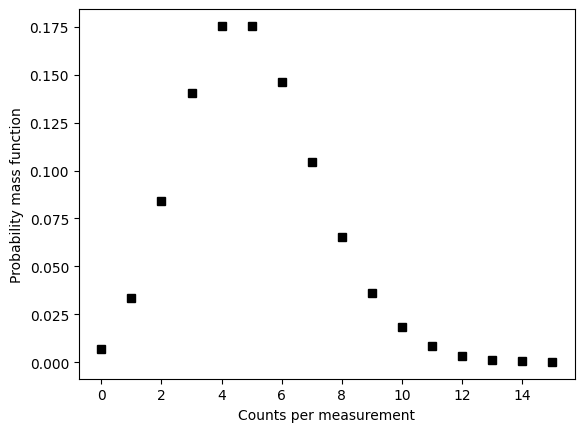

In [18]:
outcomes = np.arange(0, int(expected_counts*3)+1, 1)
pmf = st.poisson(expected_counts).pmf(outcomes)
plt.figure()
plt.plot(outcomes, pmf, "ks")
plt.xlabel("Counts per measurement")
plt.ylabel("Probability mass function")
plt.show()

<font size=3><u>**In-class discussion: What is the uncertainty on the measured counts?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Since it's Poisson, the standard deviation is the square root of the expected value!
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Compute the uncertainty on the measured counts using either a formula, or a `scipy` function.
</div>

In [19]:
counts_uncertainty = expected_counts**0.5
print(f"Uncertainty: {counts_uncertainty:.3f}")

Uncertainty: 2.236


## 1.2. Estimating the luminosity of a source


<font size=3><u>**In-class discussion: Let's do the opposite now! We found a source that emitted 5 counts. What is the luminosity of the source?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
The Poisson distribution above peaks at 5 counts, but also for 4 counts. So... if we got 4 counts, 5 would also be a good answer?
There is something weird going on! We have one measurement and we ask a question about the source! Also, we are always going to get integer multiples of the count/luminosty factor this way! But nature doesn't care about the photons we got, how far away we are, etc.
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Select three offsets, including zero, (can be negative or positive value) around the mean value and inspect the resulting distributions: what do you notice?
</div>

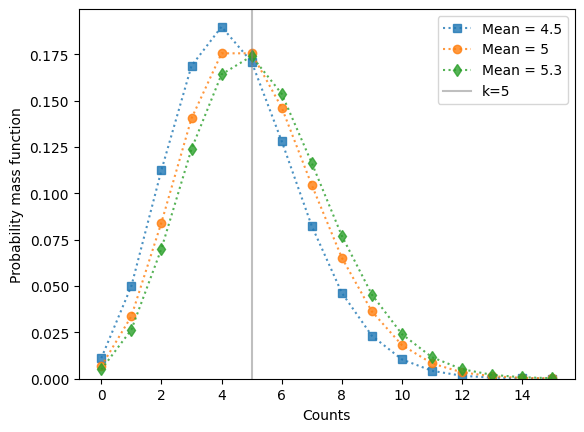

In [20]:
outcomes = np.arange(0, int(expected_counts*3)+1, 1)
plt.figure()
# try different offsets around the expected mean value and plot the PMF
for offset, marker in zip([-0.5, 0.0, 0.3], ["s", "o", "d"]):
    mean = expected_counts + offset
    plt.plot(outcomes, st.poisson(mean).pmf(outcomes), ":", marker=marker, alpha=0.8, label=f"Mean = {mean:.4g}")
plt.axvline(expected_counts, color="0.5", alpha=0.5, label="k=5")
plt.ylim(ymin=0)
plt.legend(loc="upper right")
plt.xlabel("Counts")
plt.ylabel("Probability mass function")
plt.show()

### We have multiple (actually infinite) hypothesis for the source luminosity

Before, we had the source luminosity fixed, and we wondered what we will measure, if repeating the experiment many times! This is the **frequentist approach**. And we also assigned uncertainty in the data!!!

> A frequentist assigns probabilities to data - parameters are fixed. The probability is a *frequency* of data outcomes.

But when asking about the nature of things (like in... all Science except for mathematics), then we are not interested in assigning uncertainty on the data. The data are what they are - also... they might have been fundamentally unique (some experiments cannot be repeated). We need to assign probabilities to the quantity of interest. This is the **Bayesian approach**:

$$ P(\textrm{hypothesis} | \textrm{data}) $$

> A Bayesian assigns probabilities to hypotheses. The probability is a *degree of belief* in a value of a parameter.

![image from Sivia](images/Sivia_Logic.png)

# 2. Bayes Theorem: The Foundation of Bayesian Inference

To navigate from what we can model, $P(\textrm{data} | \textrm{hypothesis})$, to what we want to know, $P(\textrm{hypothesis} | \textrm{data})$, we use Bayes Theorem. It arises from the basic rules of probability.

The joint probability of two events (or propositions) A and B occurring, $P(A, B)$, can be written in two ways:

$$ P(A, B) = P(A | B) P(B) $$

$$ P(A, B) = P(B | A) P(A) $$

Since $P(A,B)$ is the same in both expressions, we can equate them:

$$ P(A | B) P(B) = P(B | A) P(A) $$

Rearranging this gives us Bayes Theorem:

$$ P(A | B) = \dfrac{P(B | A) P(A)}{P(B)} $$

In the context of data and hypotheses, we write this as:

$$ P(\textrm{hypothesis} | \textrm{data}, I) = \dfrac{P(\textrm{data} | \textrm{hypothesis}, I) P(\textrm{hypothesis} | I)}{P(\textrm{data} | I)} $$

Here, $I$ represents all our background information and assumptions.

We made everything conditional to $I$, the **background information**: all relevant knowledge we have about the problem we are solving but are not part of the data or the specific hypothesis being tested.

For example, if we are testing whether a die is fair, the data are a sequence of outcomes (e.g., 1, 6, 3, 5, 3, 1), the hypothesis could be **the probability of rolling a 6 is $p_6$**, and $I$ = $\big\{$ all dice have 6 sides, a fair die has equiprobable sides, the laws of physics as we know them, $\cdots \big\}$.

For brevity, **we usually omit writing the $I$** in the equations, but **its always there**... somewhere in the background!

All the terms of Bayes Theorem have specific names:

*   **Posterior Probability**: $P(\text{hypothesis} | \text{data}, I)$ is the (updated) degree of belief in the hypothesis *after* considering the data.
*   **Likelihood**: $P(\text{data | hypothesis}, I)$ is the probability of observing the data *given* that the hypothesis is true. This is what we often model based on our understanding of the data generation process.
*   **Prior Probability**: $P(\text{hypothesis} | I)$ is the degree of belief in the hypothesis *before* looking at the current data. It encapsulates our previous knowledge, physical constraints, or initial assumptions.
*   **Evidence (or Marginal Likelihood)**: $P(\text{data} | I)$ is the overall probability of observing the data, averaged over all possible hypotheses. It acts as a normalization constant.

> In Bayesian Analysis we assign degrees of belief to hypotheses (prior), which we "update" using experimental data (via the likelihood), to arrive at a new, refined degree of belief in the hypotheses (posterior).

# A Deeper Look at the Components:

## Priors $P(\text{hypothesis} | I)$
The prior represents our state of knowledge about the hypothesis before we consider the current dataset. It can come from previous experiments, theoretical predictions, or fundamental principles. The choice of prior can be influential, especially with limited data, and is a key aspect of Bayesian modeling.

Priors can be broadly categorized as **informative** or **uninformative** (often, more accurately, **weakly informative**).

*   **Informative Priors**: These reflect specific, existing information about the parameter before observing the current data. This information might come from previous experiments, physical laws, or established theories. For example, if measuring the mass of a planet, an informative prior might restrict the mass to be positive and perhaps within a range plausible for planets.

*   **Uninformative/Weakly Informative Priors**: These are intended to let the data speak for themselves as much as possible, or to represent a state of relative ignorance. However, a truly "uninformative" prior is often elusive. Common approaches include:
    *   **Principle of Indifference (Uniform Priors)**: Assigns equal probability to all possible values of a parameter within a given range. For a parameter $\theta$ bounded by $\theta_{min}$ and $\theta_{max}$, $P(\theta|I) \propto 1$. While simple, a uniform prior for $\theta$ is not uniform for a non-linear transformation of $\theta$ (e.g., $\theta^2$).
    *   **Principle of Invariance**: Seeks priors that are invariant under certain transformations.
        *   **Location Invariance**: If the problem is unchanged by shifting the origin of a location parameter $\mu$ (e.g., measuring a position), a uniform prior $P(\mu|I) \propto C$ is often used. If the parameter is bounded, this becomes $P(\mu|I) = 1/(\mu_{max}-\mu_{min})$.
        *   **Scale Invariance**: If the problem depends on a scale parameter $\sigma > 0$ (e.g., a standard deviation, or a flux which can span orders of magnitude) such that the problem looks the same if we rescale our units, a prior $P(\sigma|I) \propto 1/\sigma$ is often appropriate. This is equivalent to a uniform prior on $\log \sigma$, meaning it gives equal weight to different orders of magnitude. This is also known as a Jeffreys prior for a scale parameter.
    *   **Improper Priors**: Some uninformative priors (like $P(\mu|I) \propto C$ over $(-\infty, +\infty)$, or $P(\sigma|I) \propto 1/\sigma$ over $(0, +\infty)$) do not integrate to a finite value and are called improper. They can still be used if they lead to a proper posterior distribution (one that does integrate to a finite value).

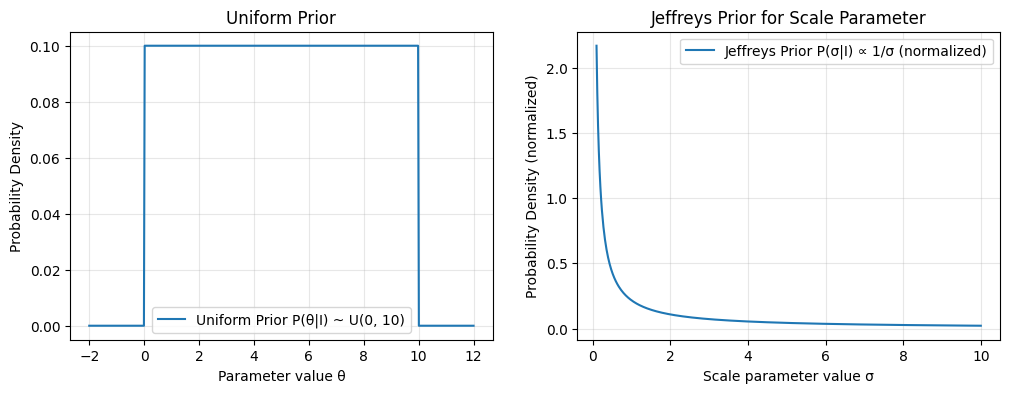

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# 1. Uniform Prior
ax = axs[0]
x_uniform = np.linspace(-2, 12, 500)
pdf_uniform = st.uniform(loc=0, scale=10).pdf(x_uniform) # Uniform between 0 and 10
ax.plot(x_uniform, pdf_uniform, label='Uniform Prior P(θ|I) ~ U(0, 10)')
ax.set_title('Uniform Prior')
ax.set_xlabel('Parameter value θ')
ax.set_ylabel('Probability Density')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Jeffreys Prior for scale parameter (visualized as 1/σ on linear scale)
ax = axs[1]
x_jeffreys = np.linspace(0.1, 10, 500)
pdf_jeffreys = 1/x_jeffreys
pdf_jeffreys_norm = pdf_jeffreys / np.trapz(pdf_jeffreys, x_jeffreys) # Normalize for plotting
ax.plot(x_jeffreys, pdf_jeffreys_norm, label='Jeffreys Prior P(σ|I) ∝ 1/σ (normalized)')
ax.set_title('Jeffreys Prior for Scale Parameter')
ax.set_xlabel('Scale parameter value σ')
ax.set_ylabel('Probability Density (normalized)')
ax.legend()

ax.grid(True, alpha=0.3)

*   **Conjugate Priors**: In some cases, the prior and the likelihood can be chosen from families of distributions such that the posterior distribution belongs to the same family as the prior. These are called conjugate priors. They offer mathematical convenience, providing closed-form solutions for the posterior.
    *   **Example: Gaussian Likelihood with Gaussian Prior**: If the likelihood for a parameter $\mu$ is Gaussian, $P(\text{data}|\mu) \sim N(\text{data}; \mu, s_D)$, based on data with sample mean $\bar{x}$ and effective standard deviation of the mean $s = \sigma_D / \sqrt{N_D}$, and the prior for $\mu$ is also Gaussian, $P(\mu|I) \sim N(\mu; \mu_P, \sigma_P)$, then the posterior distribution for $\mu$ is also Gaussian, $P(\mu|\text{data},I) \sim N(\mu; \mu_{post}, \sigma_{post})$, where:
        $$ \sigma_{post}^2 = \left( \frac{1}{\sigma_P^2} + \frac{1}{s^2} \right)^{-1} $$
        $$ \mu_{post} = \sigma_{post}^2 \left( \frac{\mu_P}{\sigma_P^2} + \frac{\bar{x}}{s^2} \right) $$
        The posterior precision ($1/\sigma_{post}^2$) is the sum of the prior precision and the data precision. The posterior mean is a precision-weighted average of the prior mean and the data mean.

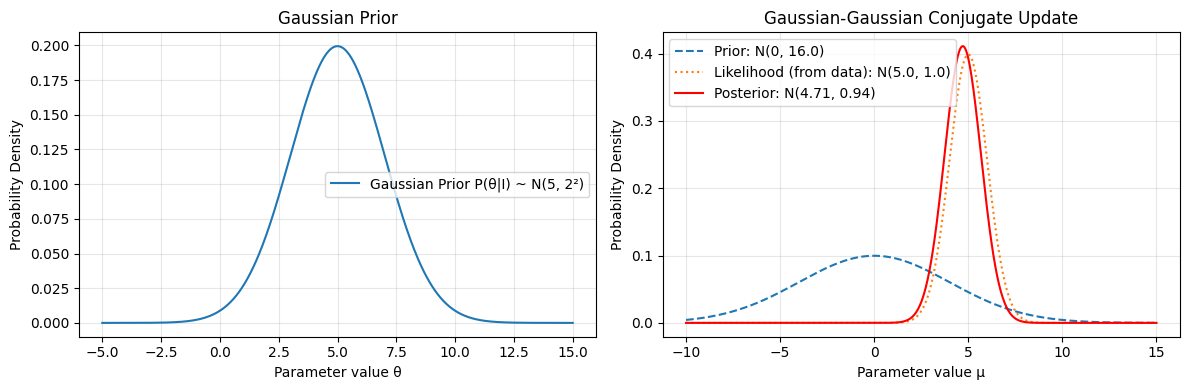

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# 3. Gaussian Prior
ax = axs[0]
x_gaussian = np.linspace(-5, 15, 500)
pdf_gaussian = st.norm(loc=5, scale=2).pdf(x_gaussian) # Gaussian N(5, 2^2)
ax.plot(x_gaussian, pdf_gaussian, label='Gaussian Prior P(θ|I) ~ N(5, 2²)')
ax.set_title('Gaussian Prior')
ax.set_xlabel('Parameter value θ')
ax.set_ylabel('Probability Density')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Gaussian-Gaussian Conjugate Update Example
ax = axs[1]
# Prior: P(μ|I) ~ N(μ_P, σ_P^2)
mu_P, sigma_P = 0, 4.0
prior_dist = st.norm(mu_P, sigma_P)

# Data: Assume we have N_D measurements x_i from N(μ, σ_D^2)
# For simplicity, let's say we have a sample mean x_bar and know s = σ_D / sqrt(N_D)
x_bar, s = 5.0, 1.0 # Likelihood centered at x_bar, with std. error of mean s
likelihood_dist = st.norm(x_bar, s) # Represents P(data|μ)

# Posterior: P(μ|data,I) ~ N(μ_post, σ_post^2)
precision_P = 1.0 / sigma_P**2
precision_data = 1.0 / s**2
sigma_post_sq = 1.0 / (precision_P + precision_data)
mu_post = sigma_post_sq * (precision_P * mu_P + precision_data * x_bar)
sigma_post = np.sqrt(sigma_post_sq)
posterior_dist = st.norm(mu_post, sigma_post)

x_gg = np.linspace(-10, 15, 500)
ax.plot(x_gg, prior_dist.pdf(x_gg), label=f'Prior: N({mu_P}, {sigma_P**2})', linestyle='--')
ax.plot(x_gg, likelihood_dist.pdf(x_gg), label=f'Likelihood (from data): N({x_bar}, {s**2})', linestyle=':')
ax.plot(x_gg, posterior_dist.pdf(x_gg), label=f'Posterior: N({mu_post:.2f}, {sigma_post**2:.2f})', color='red')
ax.set_title('Gaussian-Gaussian Conjugate Update')
ax.set_xlabel('Parameter value μ')
ax.set_ylabel('Probability Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The choice of prior should always be justified and its impact on the results assessed, especially if strong claims are made from weakly informative data.

## Likelihood $P(\text{data} | \text{hypothesis}, I)$
The likelihood function, $P(\text{data} | \text{hypothesis}, I)$, is the cornerstone that connects our observed data to the parameters of our hypothesis. If the data are very probable under the hypothesis, the likelihood is high. If the data are improbable, the likelihood is low. For many problems, we assume a specific mathematical form for the likelihood. Choosing an appropriate likelihood is crucial as it encapsulates our assumptions about the data-generating process. The form of the likelihood is determined by the nature of the data and the underlying physical or statistical model we believe is responsible for producing that data.

**How to Choose a Likelihood:**

The choice primarily depends on:
1.  **Type of Data**: Is the data continuous (e.g., measurements of temperature, flux), discrete counts (e.g., number of photons, detected events), binary (e.g., success/failure), or categorical?
2.  **Assumed Data-Generating Process**: What statistical distribution best describes the variability or noise in the data, given a set of model parameters?

**Common Likelihood Functions and Their Use Cases:**

Here are some commonly used likelihood functions:

*   **Gaussian (Normal) Likelihood**:
    *   **Use Case**: For continuous data that are expected to be symmetrically distributed around a mean value, or when the errors are assumed to be normally distributed (often invoked by the Central Limit Theorem).
    *   **Example**: Measuring the brightness of a star, where instrumental noise and other random errors lead to Gaussian fluctuations around the true brightness.
    *   **Form**: If we have $N$ data points $x_i$, and our hypothesis is that they are drawn from a Gaussian with mean $\mu$ and standard deviation $\sigma$ (where $\mu$ and/or $\sigma$ could be our parameters):
        $$ P(\{x_i\} | \mu, \sigma, I) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(-\frac{(x_i-\mu)^2}{2\sigma^2}\right) $$

*   **Poisson Likelihood**:
    *   **Use Case**: For count data, representing the number of events occurring in a fixed interval of time or space, assuming events are independent and occur at a constant average rate.
    *   **Example**: Counting the number of X-ray photons ($k$) detected from a celestial source in a given observation time, where the expected mean count is $\lambda$. This is the primary example in this notebook.
    *   **Form**: If we observe $k$ counts and the expected mean is $\lambda$:
        $$ P(k | \lambda, I) = \frac{\lambda^k e^{-\lambda}}{k!} $$

*   **Binomial Likelihood**:
    *   **Use Case**: For data representing the number of "successes" ($k$) in a fixed number of $n$ independent Bernoulli trials, where each trial has a probability $p$ of success.
    *   **Example**: Determining the probability $p$ that a galaxy is a spiral type, given that we observed $k$ spiral galaxies in a sample of $n$ galaxies.
    *   **Form**:
        $$ P(k | n, p, I) = \binom{n}{k} p^k (1-p)^{n-k} $$

*   **Exponential Likelihood**:
    *   **Use Case**: For modeling positive, continuous data, often representing waiting times between events in a Poisson process, or the decay rate of a particle.
    *   **Example**: Modeling the time intervals between successive detections of high-energy cosmic rays, assuming they arrive according to a Poisson process with rate $\lambda$. The likelihood for an observed interval $t$ is $P(t | \lambda, I) = \lambda e^{-\lambda t}$.
    *   **Form** (for a single data point $x$ with rate parameter $\lambda$ or scale parameter $\beta=1/\lambda$):
        $$ P(x | \lambda, I) = \lambda e^{-\lambda x} \quad \text{or} \quad P(x | \beta, I) = \frac{1}{\beta} e^{-x/\beta} $$

*   **Uniform Likelihood**:
    *   **Use Case**: When, given the hypothesis, any data value within a specific range $[a,b]$ is considered equally probable, and values outside this range are impossible.
    *   **Example**: If a model predicts a signal must lie between $\theta_1$ and $\theta_2$, and we have no reason to prefer any value within this range over another.
    *   **Form**: For a data point $x$:
        $$ P(x | \theta_1, \theta_2, I) = \begin{cases} \frac{1}{\theta_2 - \theta_1} & \text{if } \theta_1 \le x \le \theta_2 \\ 0 & \text{otherwise} \end{cases} $$

**Constructing a Likelihood:**

*   **Based on Physical Models**: Often, the likelihood is derived from a physical model of the measurement process. For instance, if your instrument has a known response function, this function will inform the likelihood.
*   **Combining Distributions**: More complex likelihoods can be built by combining simpler ones, e.g., a mixture model if data can arise from different processes, or a convolution if there are multiple sources of error.
*   **Numerical Likelihoods**: If an analytical form is intractable, the likelihood might be evaluated numerically based on simulations of the data-generating process for different parameter values.

**Important Considerations:**

*   The likelihood is a function of the **parameters** of your hypothesis, for the **fixed, observed data**.
*   The choice of likelihood is a modeling choice and should be justified. If the assumptions underlying the chosen likelihood are strongly violated by the data-generating process, the Bayesian inference results may be misleading.
*   Sometimes, robust likelihoods (e.g., Student's t-distribution instead of Gaussian for data with heavy tails) are used to make inferences less sensitive to outliers.

Understanding and correctly specifying the likelihood is arguably the most critical step in a Bayesian (and frequentist) analysis, as it defines how the data inform our beliefs about the hypotheses.

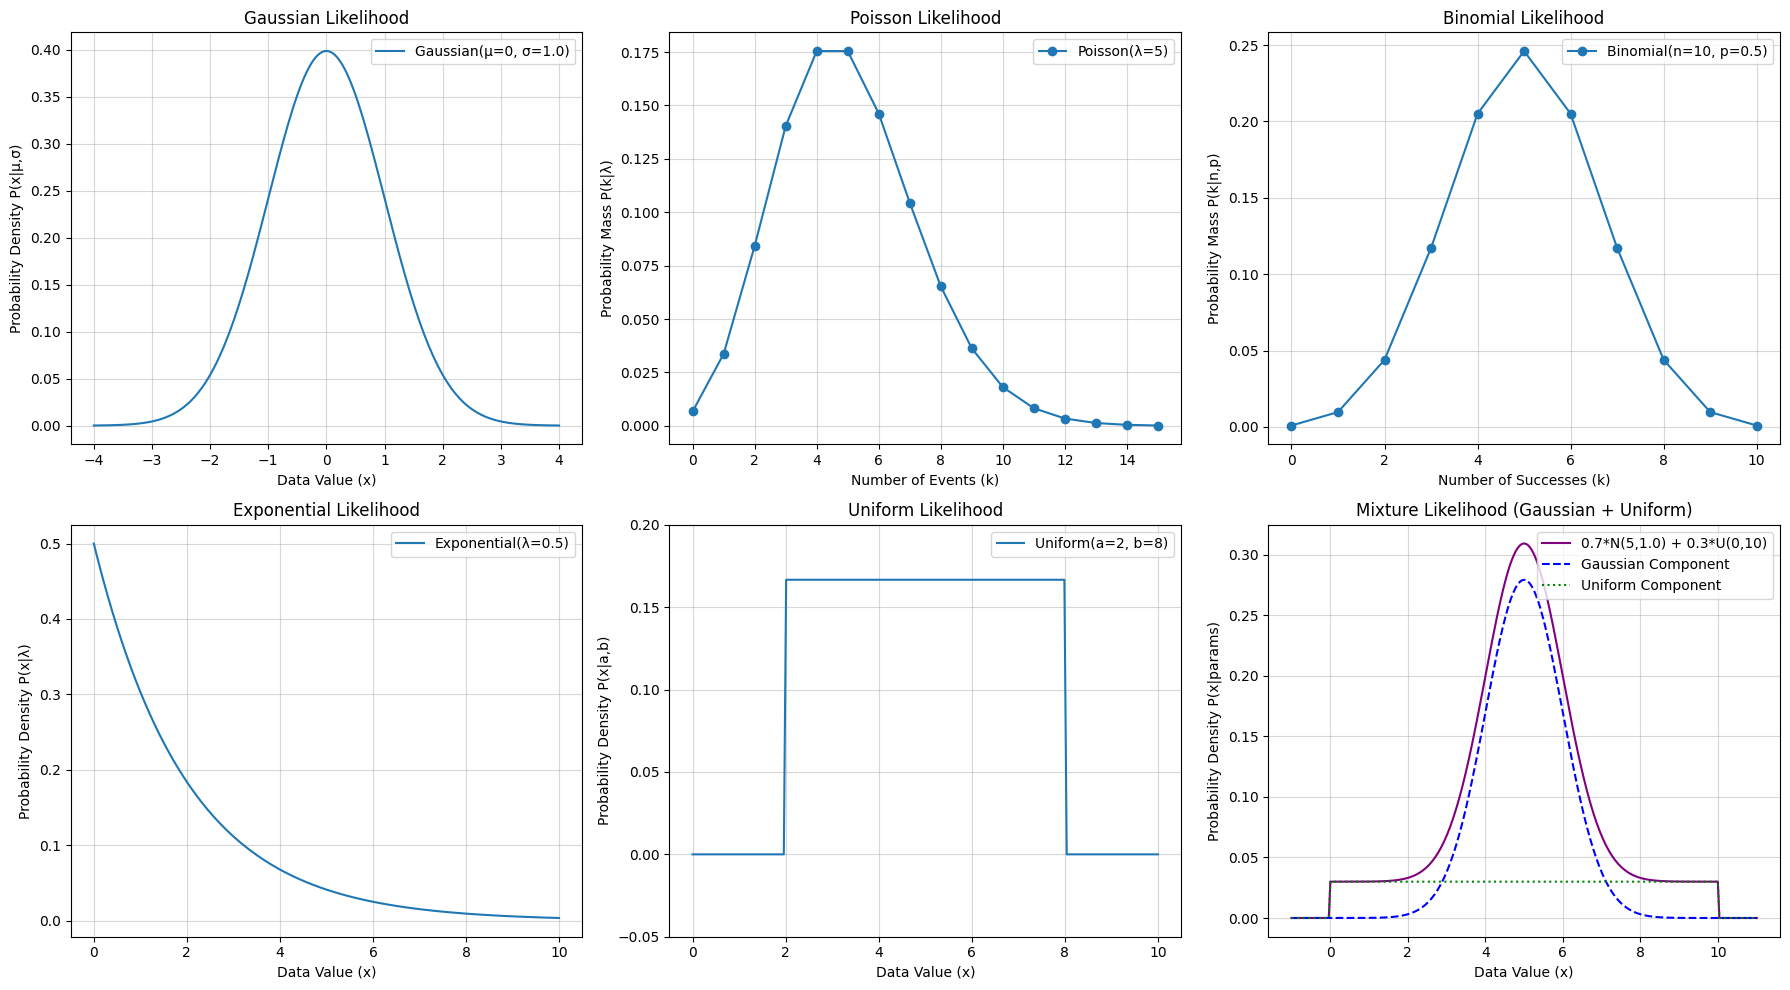

In [ ]:
# Example Plots of Common Likelihood Functions
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.ravel() # Flatten the 2x3 array of axes for easy iteration

# 1. Gaussian Likelihood
mu_g, sigma_g = 0, 1.0 # Example parameters: mean, std_dev
x_g = np.linspace(mu_g - 4*sigma_g, mu_g + 4*sigma_g, 200)
pdf_g = st.norm.pdf(x_g, loc=mu_g, scale=sigma_g)
axs[0].plot(x_g, pdf_g, label=f'Gaussian(μ={mu_g}, σ={sigma_g})')
axs[0].set_title('Gaussian Likelihood')
axs[0].set_xlabel('Data Value (x)')
axs[0].set_ylabel('Probability Density P(x|μ,σ)')
axs[0].legend()
axs[0].grid(True, alpha=0.5)

# 2. Poisson Likelihood
lambda_p = 5 # Example parameter: expected rate λ
k_p = np.arange(0, lambda_p * 3 + 1)
pmf_p = st.poisson.pmf(k_p, mu=lambda_p)
axs[1].plot(k_p, pmf_p, 'o-', label=f'Poisson(λ={lambda_p})')
axs[1].set_title('Poisson Likelihood')
axs[1].set_xlabel('Number of Events (k)')
axs[1].set_ylabel('Probability Mass P(k|λ)')
axs[1].legend()
axs[1].grid(True, alpha=0.5)

# 3. Binomial Likelihood
n_b, p_b = 10, 0.5 # Example parameters: n trials, probability of success p
k_b = np.arange(0, n_b + 1)
pmf_b = st.binom.pmf(k_b, n=n_b, p=p_b)
axs[2].plot(k_b, pmf_b, 'o-', label=f'Binomial(n={n_b}, p={p_b:.1f})')
axs[2].set_title('Binomial Likelihood')
axs[2].set_xlabel('Number of Successes (k)')
axs[2].set_ylabel('Probability Mass P(k|n,p)')
axs[2].legend()
axs[2].grid(True, alpha=0.5)

# 4. Exponential Likelihood
lambda_e = 0.5 # Example parameter: rate λ (scale = 1/λ)
x_e = np.linspace(0, 5 / lambda_e, 200)
pdf_e = st.expon.pdf(x_e, scale=1/lambda_e) # scipy.stats.expon uses scale = 1/λ
axs[3].plot(x_e, pdf_e, label=f'Exponential(λ={lambda_e})')
axs[3].set_title('Exponential Likelihood')
axs[3].set_xlabel('Data Value (x)')
axs[3].set_ylabel('Probability Density P(x|λ)')
axs[3].legend()
axs[3].grid(True, alpha=0.5)

# 5. Uniform Likelihood
a_u, b_u = 2, 8 # Example parameters: lower bound a, upper bound b
x_u = np.linspace(a_u - 2, b_u + 2, 200)
pdf_u = st.uniform.pdf(x_u, loc=a_u, scale=b_u-a_u)
axs[4].plot(x_u, pdf_u, label=f'Uniform(a={a_u}, b={b_u})')
axs[4].set_title('Uniform Likelihood')
axs[4].set_xlabel('Data Value (x)')
axs[4].set_ylabel('Probability Density P(x|a,b)')
axs[4].legend()
axs[4].grid(True, alpha=0.5)
axs[4].set_ylim(bottom=-0.05, top=pdf_u.max()*1.2 if pdf_u.max() > 0 else 0.2) # Adjust y-limits for visibility

# 6. Mixture Model: Gaussian + Uniform Background
mu_mix, sigma_mix = 5, 1.0  # Gaussian parameters
a_mix, b_mix = 0, 10        # Uniform background parameters
weight_gauss = 0.7          # Weight of the Gaussian component
weight_uniform = 1.0 - weight_gauss

x_mix = np.linspace(min(a_mix, mu_mix - 4*sigma_mix) -1, max(b_mix, mu_mix + 4*sigma_mix) +1, 300)
pdf_gauss_mix = st.norm.pdf(x_mix, loc=mu_mix, scale=sigma_mix)
pdf_uniform_mix = st.uniform.pdf(x_mix, loc=a_mix, scale=b_mix-a_mix)

pdf_mixture = weight_gauss * pdf_gauss_mix + weight_uniform * pdf_uniform_mix

axs[5].plot(x_mix, pdf_mixture, label=f'{weight_gauss:.1f}*N({mu_mix},{sigma_mix}) + {weight_uniform:.1f}*U({a_mix},{b_mix})', color='purple')
axs[5].plot(x_mix, weight_gauss * pdf_gauss_mix, label=f'Gaussian Component', color='blue', linestyle='--')
axs[5].plot(x_mix, weight_uniform * pdf_uniform_mix, label=f'Uniform Component', color='green', linestyle=':')
axs[5].set_title('Mixture Likelihood (Gaussian + Uniform)')
axs[5].set_xlabel('Data Value (x)')
axs[5].set_ylabel('Probability Density P(x|params)')
axs[5].legend()
axs[5].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

## The Evidence $P(\text{data} | I)$:
The evidence is the probability of the data, averaged over all possible values of the hypothesis parameters, weighted by their prior probabilities. If $\theta$ represents the parameters of our hypothesis, then:
$$ P(\text{data} | I) = \int P(\text{data} | \theta, I) P(\theta | I) d\theta $$
In parameter estimation problems (where we are trying to find the best values of $\theta$), the evidence $P(\text{data} | I)$ is a constant for a given dataset and model form. It ensures that the posterior probability distribution is properly normalized (i.e., integrates/sums to 1). While it often cancels out or is ignored in parameter estimation (as we often care about $P(\text{hypothesis} | \text{data}) \propto P(\text{data} | \text{hypothesis}) P(\text{hypothesis})$), the evidence is **crucial for model comparison**, a topic we will explore later. It allows us to compare how well different models (different forms of hypotheses or priors) explain the data.

## 2.1. Back to our counting experiment: what does Reverend Bayes say about it...

$$ P(\text{hypothesis} | \text{data}) = P(\lambda | k) \propto P(k | \lambda) P(\lambda) $$

where we ignored the evidence since its just a normalization constant for parameter estimation.

### 2.1.1. Assigning a prior belief on the source luminosity (and therefore its expected counts, $\lambda$)

We need to choose a prior $P(\lambda | I)$.

**Option 1: Uniform Prior over a finite range (Principle of Indifference)**
We may have a constraint - that $\lambda$ cannot be above 20 because that would make it an AGN, and we know from other measurements that its not (this is background information $I$):

$$ P(\lambda | I) = \begin{cases} C & 0\leq \lambda < 20 \\ 0 & \text{elsewhere} \end{cases}$$

The constant $C$ would be $1/20$ to normalize the prior. However, since we are interested in the shape of the posterior $P(\lambda | k) \propto P(k | \lambda) P(\lambda)$, we can often absorb normalization constants.

Then using the Poisson likelihood as in the frequentist approach:

$$ P(\lambda | k) \propto P(k | \lambda) P(\lambda) \propto \begin{cases} \dfrac{\lambda^k e^{-\lambda}}{k!}  & 0\leq \lambda < 20 \\ 0 & \text{elsewhere} \end{cases}$$

**Option 2: Uniform (Improper) Prior for $\lambda \ge 0$ (Agnostic approach)**
Maybe we have no other information and want to be **agnostic** about $\lambda$ (other than it must be non-negative, as its an expected count):

$$  P(\lambda | I) = \text{const.}, \quad \lambda \ge 0 $$

This is an **improper prior** because its integral over $[0, \infty)$ diverges. However, it can still lead to a proper posterior. Since its just a constant, it does not affect the proportionality for the posterior shape:

$$ P(\lambda | k) \propto P(k | \lambda) P(\lambda) \propto P(k | \lambda) \propto \dfrac{\lambda^k e^{-\lambda}}{k!} \quad \text{for } \lambda \ge 0$$

<font size=3><u>**In-class discussion: Are we back to frequentism using uniform priors?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
    No! Bayesian inference is not just frequentism + priors. Even if the formula for the posterior $P(\lambda|k)$ looks proportional to the likelihood $P(k|\lambda)$ when using a flat prior, the interpretation is fundamentally different. 
    The posterior $P(\lambda|k)$ is a probability distribution for the parameter $\lambda$, given the observed data $k$. The likelihood $P(k|\lambda)$ is a probability distribution for the data $k$, given a fixed parameter $\lambda$.
    The posterior $P(\lambda | k) \propto \lambda^k e^{-\lambda}$ (for $k$ fixed, $\lambda \ge 0$) is a probability density function for the continuous quantity $\lambda$. In fact, it is a **Gamma distribution**: specifically, $\text{Gamma}(\text{shape}=k+1, \text{scale}=1)$ or $\text{Gamma}(\alpha=k+1, \beta=1)$ depending on parameterization (e.g., if PDF is $f(x;\alpha,\beta) = \frac{\beta^\alpha x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$).
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Compute the posterior values for the trial $\lambda$ values. What is the best-fitting value for $\lambda$?
</div>

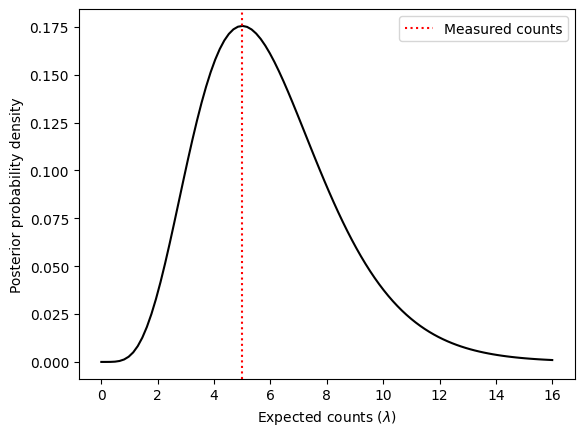

In [6]:
measure_counts = 5.0
lambda_values = np.linspace(0, int(measure_counts*3)+1, 100)
posteriors = st.poisson.pmf(measure_counts, lambda_values)

plt.figure()
plt.plot(lambda_values, posteriors, "k-")
plt.xlabel("Expected counts ($\lambda$)")
plt.ylabel("Posterior probability density")
plt.axvline(5.0, color="r", ls=":", label="Measured counts")
plt.legend(loc="upper right")
plt.show()

### Parameter Marginalization: Focusing on What Matters

Often, our statistical models involve multiple parameters. However, we might only be interested in a subset of these parameters, while the others are necessary for a complete model but not of direct interest. These latter parameters are often called **nuisance parameters**.

For example, when measuring the flux ($\mu$) of a star, the noise level or background uncertainty ($\sigma$) in our measurements might also be an unknown parameter that we need to account for in our model. While we need to estimate $\sigma$ to properly assess $\mu$, our primary goal is the value of $\mu$, making $\sigma$ a nuisance parameter in this context.

Bayesian inference provides a natural and powerful way to deal with nuisance parameters through **marginalization**. If we have a joint posterior probability distribution for all parameters, say $P(\theta_1, \theta_2, ..., \theta_k | \text{data}, I)$, and we are only interested in a specific parameter (or subset of parameters) $\theta_1$, we can obtain its marginal posterior probability distribution by integrating (or summing, for discrete parameters) the joint posterior over all other nuisance parameters ($\theta_2, ..., \theta_k$):

$$ P(\theta_1 | \text{data}, I) = \int \dots \int P(\theta_1, \theta_2, \dots, \theta_k | \text{data}, I) d\theta_2 \dots d\theta_k $$

For a two-parameter case (e.g., $\mu$ and $\sigma$):
$$ P(\mu | \text{data}, I) = \int P(\mu, \sigma | \text{data}, I) d\sigma $$

The result, $P(\theta_1 | \text{data}, I)$, is the posterior probability distribution for $\theta_1$ alone, fully accounting for the uncertainty in the nuisance parameters. This means that our inferences about $\theta_1$ (like its credible interval) have properly incorporated the fact that the other parameters were not known precisely.

This is a significant advantage of the Bayesian framework. It allows us to propagate uncertainty from all parts of our model into the final inference for the quantities we care about. In frequentist statistics, dealing with nuisance parameters can sometimes be more complex, often involving techniques like profiling the likelihood or using specific test statistics designed to be insensitive to them.

#### Example: Estimating Stellar Flux with Background as a Nuisance Parameter**

Let’s apply marginalization in a practical setting.

Suppose we observe a noisy measurement of the total brightness from a patch of sky. This total brightness includes contributions from:

* The **flux** $F$ of a star (our parameter of interest),
* The **background** $B$ from surrounding light or instrumental effects (a nuisance parameter),
* And **Gaussian noise** with known standard deviation $\sigma$.

We model the observed value $x$ as:

$$
x \sim \mathcal{N}(F + B, \sigma^2)
$$

We place a **broad prior** on $F$, reflecting that the star could be relatively bright or dim, and a **more informative prior** on $B$, reflecting prior knowledge about typical background levels.

Although both $F$ and $B$ are unknown, we are only interested in the posterior for $F$. To obtain it, we **marginalize out** the nuisance parameter $B$:

$$
P(F \mid x) = \int P(F, B \mid x) \, dB
$$

Observed value: 12.50


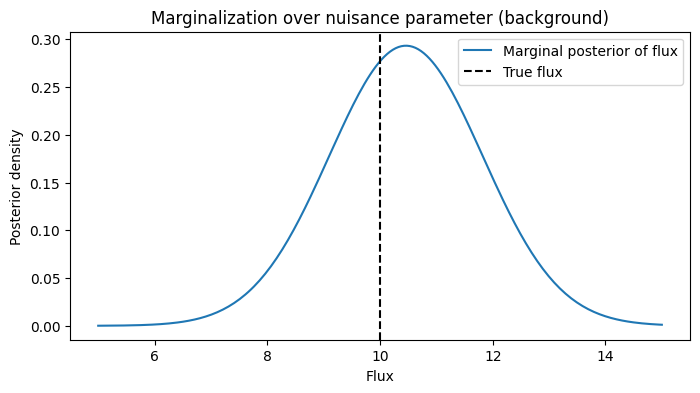

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad


# Simulated data
true_flux = 10.0
true_background = 2.0
sigma = 1.0

# One observation (flux + background + noise)
np.random.seed(42)
obs = np.random.normal(loc=true_flux + true_background, scale=sigma)

print(f"Observed value: {obs:.2f}")

# Define priors
def prior_flux(F):
    return norm.pdf(F, loc=10, scale=5)  # broad prior

def prior_background(B):
    return norm.pdf(B, loc=2, scale=1)  # informed prior

# Likelihood
def likelihood(obs, F, B):
    return norm.pdf(obs, loc=F + B, scale=sigma)

# Posterior (unnormalized, joint in F and B)
def joint_posterior(F, B):
    return likelihood(obs, F, B) * prior_flux(F) * prior_background(B)

# Marginal posterior over F (integrate out B)
def marginal_posterior_F(F):
    integrand = lambda B: joint_posterior(F, B)
    result, _ = quad(integrand, -np.inf, np.inf)
    return result

# Evaluate marginal posterior over a grid
F_vals = np.linspace(5, 15, 200)
posterior_vals = np.array([marginal_posterior_F(F) for F in F_vals])

# Normalize
posterior_vals /= np.trapz(posterior_vals, F_vals)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(F_vals, posterior_vals, label='Marginal posterior of flux')
plt.axvline(true_flux, color='k', linestyle='--', label='True flux')
plt.xlabel('Flux')
plt.ylabel('Posterior density')
plt.legend()
plt.title('Marginalization over nuisance parameter (background)')
plt.show()


## Hierarchical Bayesian Modeling

**Hierarchical Bayesian modeling** (HBM) is one of the most powerful tools in the Bayesian toolbox. At its core, it’s a structured way of doing inference when your data comes from multiple sources, levels, or populations — and you want to model both the *individual units* and their *shared structure*.

What makes it “hierarchical” is that **you don’t just place priors on parameters — you also place priors on the priors**. That is, the *parameters of your prior distributions* (called **hyperparameters**) are also inferred from the data. And those get their own priors, called **hyperpriors**. The result is a **multi-level model**, where inference flows both bottom-up and top-down.

### A motivating example

Imagine we measure the brightness of $N$ different stars, each with multiple noisy observations. The natural hierarchy here looks like:

1. **Level 1 (Data):**
   $m_{ij}$ is the apparent magnitude of star $i$ in observation $j$ — this is what we actually measure.

2. **Level 2 (Latent object parameters):**
   Each star $i$ has a true magnitude $M_i$, which we can’t observe directly, but infer from the noisy data.

3. **Level 3 (Population hyperparameters):**
   We assume that the true magnitudes $M_i$ are drawn from a population distribution with unknown mean $\mu_M$ and scatter $\sigma_M$.

This gives rise to the following generative model:

$$
\begin{aligned}
M_i &\sim \mathcal{N}(\mu_M, \sigma_M^2), \\\\
m_{ij} &\sim \mathcal{N}(M_i, \sigma_{\text{photon}}^2),
\end{aligned}
$$

with **priors** on the hyperparameters, for example:

* $\mu_M \sim \mathcal{N}(0, 10^2)$,
* $\sigma_M \sim \text{Half-Cauchy}(0, 5)$.

We fit all the layers *simultaneously* using Bayesian inference (e.g., MCMC or variational methods). After inference, we get:

* a posterior for each star’s true brightness $M_i$, and
* a posterior for the population parameters $(\mu_M, \sigma_M)$.

This simultaneous inference allows information to *flow between stars*: a noisy or poorly measured star can “borrow strength” from the better-measured population.

---

### Why is this useful?

Hierarchical modeling isn’t just fancy terminology — it brings several concrete advantages:

#### 1. **Sharing statistical strength**

In classic Bayesian models, we treat each object separately. But if we think that objects come from a shared distribution (like all stars belonging to a stellar population), then it makes sense to infer them *jointly*. This enables “partial pooling” — each object's parameter estimate is pulled toward the population mean, especially when its data is weak.

> *Example*: A star with only one noisy brightness measurement will still get a reasonable estimate of its true magnitude, informed by what we learned from the other stars.

#### 2. **Capturing complex structure**

Hierarchical models let us **separate individual variability from population-level structure**, allowing us to answer both specific and global questions:

* What is the true brightness of star 27?
* What is the overall distribution of star magnitudes in this field?

This is essential in fields like:

* **Cosmology**: modeling galaxy shapes and masses across surveys.
* **Gravitational-wave astronomy**: estimating black hole masses while also inferring the astrophysical mass distribution.
* **Exoplanets**: learning planet properties *and* the population distribution of their orbits ([Foreman-Mackey et al. 2014](https://arxiv.org/abs/1406.3020)).

#### 3. **Robust uncertainty propagation**

Uncertainty propagates *through all levels* of the model — from data, to parameters, to hyperparameters. This avoids overconfidence, especially when individual datasets are small or noisy.

> *In other words*: we don’t pretend we know the true prior. We learn it from the data.

#### 4. **Taming prior sensitivity**

When working with small datasets, inference can be very sensitive to the choice of prior. HBMs address this by **learning the prior from the data itself** — effectively regularizing and reducing bias.

This is especially important in situations like:

* Rare events (e.g., rocket launches, gravitational wave detections).
* Small samples (e.g., exotic galaxies or new transients).
* Systematic uncertainties (e.g., unknown noise levels or calibration factors).

---

### Bonus: it’s everywhere in modern astrophysics!

Hierarchical models are not just theoretical — they’re now central to many areas of astrophysics:

* **Black hole mergers**: estimate masses/spins of individual events *and* population properties simultaneously ([Moore & Gerosa 2021](https://arxiv.org/abs/2108.02462), [Taylor & Gerosa 2018](https://arxiv.org/abs/1806.08365)).
* **Weak lensing cosmology**: jointly infer galaxy shapes, redshifts, and cosmological parameters, while marginalizing over nuisance parameters like shear calibration.
* **Exoplanet demographics**: learn orbital period and size distributions from Kepler and TESS observations.
